In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [6]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [7]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= locations

In [55]:
#only not null, not zero and less that 10 hours to solve
df = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 21600) & (df['Respond to Available']>25)]

In [9]:
df.shape

(2046497, 44)

In [56]:
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df1 = df.drop(columns=['Call Number', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Supervisor District', 'Original Priority',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay',  
                      'RowID', 'Battalion', 'ALS Unit'], errors='ignore')

In [57]:
df1 = df1.dropna(how='any') 

In [41]:
df1.shape

(2030167, 18)

In [58]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421116 entries, 1 to 1647781
Data columns (total 17 columns):
Unit ID                                 1421116 non-null object
Call Type                               1421116 non-null object
Zipcode of Incident                     1421116 non-null int64
Station Area                            1421116 non-null object
Box                                     1421116 non-null float64
Number of Alarms                        1421116 non-null int64
Unit Type                               1421116 non-null object
Unit sequence in call dispatch          1421116 non-null int64
Fire Prevention District                1421116 non-null object
Neighborhooods - Analysis Boundaries    1421116 non-null object
Call to Dispatch                        1421116 non-null float64
Weekofyear                              1421116 non-null int64
Hours                                   1421116 non-null int64
Minutes                                 1421116 non-null i

In [14]:
cat_features=[
    0,
    1,
    3,
    6,
    8,
    9
]

In [59]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [60]:
model = CatBoostRegressor(iterations=100, depth=10,learning_rate=0.1)
model.fit(train_pool)

0:	learn: 1990.5081786	total: 2.88s	remaining: 4m 45s
1:	learn: 1849.6716644	total: 6s	remaining: 4m 54s
2:	learn: 1726.9030148	total: 9.29s	remaining: 5m
3:	learn: 1620.5083669	total: 11.8s	remaining: 4m 43s
4:	learn: 1528.6234168	total: 14.1s	remaining: 4m 27s
5:	learn: 1449.7895318	total: 16.5s	remaining: 4m 19s
6:	learn: 1382.1818529	total: 19.3s	remaining: 4m 16s
7:	learn: 1324.3692647	total: 22.3s	remaining: 4m 16s
8:	learn: 1275.0695938	total: 25.8s	remaining: 4m 20s
9:	learn: 1233.5847856	total: 28.9s	remaining: 4m 20s
10:	learn: 1198.6629961	total: 32.1s	remaining: 4m 19s
11:	learn: 1168.8913399	total: 34.7s	remaining: 4m 14s
12:	learn: 1144.7417068	total: 38.6s	remaining: 4m 18s
13:	learn: 1124.4900619	total: 42.3s	remaining: 4m 19s
14:	learn: 1107.2170307	total: 45.4s	remaining: 4m 17s
15:	learn: 1092.4529609	total: 48.5s	remaining: 4m 14s
16:	learn: 1079.3909370	total: 51.2s	remaining: 4m 9s
17:	learn: 1068.6454582	total: 53.9s	remaining: 4m 5s
18:	learn: 1059.6120442	total

In [61]:
model.score(test_pool, y_test)  #

959.6229229843467

In [62]:
pred = model.predict(test_pool)

In [63]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(5)

,Unit ID,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Neighborhooods - Analysis Boundaries,Call to Dispatch,Weekofyear,Hours,Minutes,Hospital or Transport,0,1,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1647782,E12,Medical Incident,94117,12,5143.0,1,ENGINE,1,5,Haight Ashbury,109.0,23,0,1,0,37.765401,-122.446920,798.0,722.345832,75.654168,5.723553e+03,1556.89221,-758.89221
1647783,M21,Medical Incident,94117,12,5143.0,1,MEDIC,2,5,Haight Ashbury,109.0,23,0,1,1,37.765401,-122.446920,2715.0,3140.823522,-425.823522,1.813257e+05,1556.89221,1158.10779
1647784,84,Medical Incident,94102,1,1455.0,1,MEDIC,1,2,Tenderloin,111.0,23,0,2,1,37.781119,-122.412597,3340.0,3260.039377,79.960623,6.393701e+03,1556.89221,1783.10779
1647785,E03,Medical Incident,94102,1,1455.0,1,ENGINE,2,2,Tenderloin,111.0,23,0,2,0,37.781119,-122.412597,312.0,430.143349,-118.143349,1.395785e+04,1556.89221,-1244.89221
1647787,E14,Citizen Assist / Service Call,94121,14,7217.0,1,ENGINE,1,7,Outer Richmond,142.0,23,0,6,0,37.784762,-122.486225,3744.0,1077.388498,2666.611502,7.110817e+06,1556.89221,2187.10779


In [64]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [65]:
mae

590.0762675548675

In [66]:
mse

920876.1543170215

In [67]:
rmse

959.6229229843467

In [68]:
determanation_score

0.6680257973504993

In [25]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1321.861401961035
mse_mean: 2787813.019818711
mrse_mean: 1669.6745251152126


In [26]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Unit ID', 3.5261619709332623),
 ('Call Type', 4.846185573847623),
 ('Zipcode of Incident', 1.7027669113551278),
 ('Station Area', 1.3459119047897528),
 ('Box', 2.8370940277866565),
 ('Number of Alarms', 14.061306561784868),
 ('Unit Type', 10.852290158303887),
 ('Unit sequence in call dispatch', 6.814616897523427),
 ('Fire Prevention District', 1.5079524017537211),
 ('Neighborhooods - Analysis Boundaries', 1.4758541918679036),
 ('Call to Dispatch', 3.4364287588214983),
 ('Weekofyear', 1.1681765828665176),
 ('Hours', 3.6451127079461307),
 ('Minutes', 1.133360747710849),
 ('Hospital or Transport', 36.29725153999676),
 (0, 2.80335721626495),
 (1, 2.546171846447061)]

[('Battalion', 0.5078027445356504),
 ('Station Area', 6.135001357254266),
 ('Box', 9.114046028348575),
 ('Original Priority', 1.9631004892661137),
 ('ALS Unit', 0.8674294353822795),
 ('Call Type Group', 3.333459641176911),
 ('Unit Type', 41.73743300645736),
 ('Fire Prevention District', 1.5738692854230882),
 ('Supervisor District', 1.5693252610655513),
 ('Month', 0.5003596981995669),
 ('WeekDay', 0.7519625648056559),
 ('Weekofyear', 1.623724419771495),
 ('Hours', 8.179958110857296),
 ('Minutes', 1.0530441606569498),
 ('Call Type Merged', 21.08948379679924)]
 
 [('Station Area', 6.994516107181966),
 ('Box', 5.876354709490432),
 ('Original Priority', 0.9627007503785607),
 ('Call Type Group', 1.29599635276719),
 ('Unit Type', 60.51084666020504),
 ('Fire Prevention District', 0.3122714646717646),
 ('Supervisor District', 0.5588749902917611),
 ('Weekofyear', 0.0),
 ('Hours', 3.0604472528149556),
 ('Minutes', 0.0),
 ('Call Type Merged', 20.427991712198327)]

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

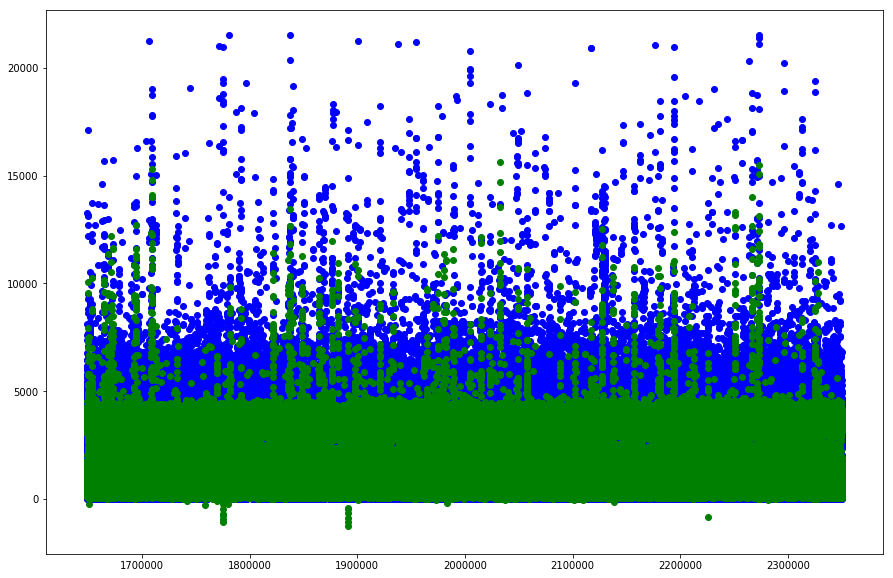

In [28]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

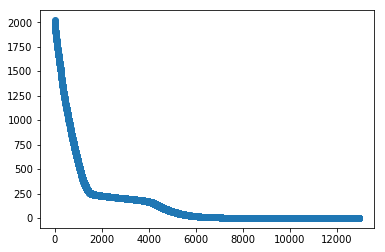

In [47]:
plt.scatter(range(0,12957), df1['Respond to Available'].value_counts())

In [82]:
df1[df1['Respond to Available']> 25n000].count()  #2046293

Unit ID                                 191
Call Type                               191
Zipcode of Incident                     191
Station Area                            191
Box                                     191
Number of Alarms                        191
Unit Type                               191
Unit sequence in call dispatch          191
Fire Prevention District                191
Neighborhooods - Analysis Boundaries    191
Respond to Available                    191
Call to Dispatch                        191
Weekofyear                              191
Hours                                   191
Minutes                                 191
Hospital or Transport                   191
0                                       191
1                                       191
dtype: int64

###### df1[df['Respond to Available']==0]

389